In [75]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/opt/miniconda3/envs/torchtf/lib/python38.zip', '/opt/miniconda3/envs/torchtf/lib/python3.8', '/opt/miniconda3/envs/torchtf/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/torchtf/lib/python3.8/site-packages', '/opt/miniconda3/envs/torchtf/lib/python3.8/site-packages/setuptools/_vendor', '../', '../']


In [76]:
from dataset import CANDataset #Using v2 if not include Timestamp
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from util import TwoCropTransform, AverageMeter
from torch.utils.data import DataLoader

In [3]:
seed = 1
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
device = torch.device("mps")

In [79]:

can_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# train_dataset = CANDataset(root_dir='../data/Car-Hacking/all_features/v2/TFRecord_w32_s32/2', window_size=32, is_train=True,
#                     transform=TwoCropTransform(can_transform))
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [80]:
# /Users/hieutran/lab/unicon-ids/data/can-ml/preprocessed/all_features/TFRecord_w32_s16/2
test_dataset = CANDataset(root_dir='../data/can-ml/preprocessed/all_features/TFRecord_w32_s16/2', window_size=32, is_train=False, transform=can_transform)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [81]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [8]:
from networks.resnet_big import ConResNet
from networks.resnet_big import LinearClassifier


model = ConResNet('resnet50')
classifier = LinearClassifier(num_classes=10)

In [82]:
save_path = '../save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_temp_0.07_mixup_lambda_0.5_trial_can_ml_cosine_warm/'
# /Users/hieutran/lab/unicon-ids/save/CAN-ML_models/UniCon/UniCon_CAN-ML_resnet50_lr_0.05_decay_0.0001_bsz_128_temp_0.07_mixup_lambda_0.5_trial_can_ml_cosine_warm
ckpt_epoch = 143
# model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path, weights_only=False)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [83]:
class_model_path = f'{save_path}/ckpt_class_epoch_{ckpt_epoch}.pth'
# class_model_path = f'{save_path}/last.pth'
ckpt = torch.load(class_model_path, weights_only=False)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [84]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 2048), dtype=float)

model = model.to(device)
classifier = classifier.to(device)
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader):
        # images = images.cuda(non_blocking=True)
        images = images.to(device, non_blocking=True)
        embs = model.encoder(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()

        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)
        

# After the loop, total_pred, total_label, and total_embs will have accumulated data


100%|██████████| 205/205 [00:38<00:00,  5.31it/s]


In [85]:
target_names = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
report = classification_report(total_label, total_pred, target_names=target_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     22161
    Combined       0.97      0.95      0.96      1186
         DoS       0.99      0.99      0.99       201
       Fuzzy       1.00      0.88      0.94       232
        Gear       0.98      0.75      0.85       122
    Interval       0.99      0.98      0.98      1157
         RPM       0.99      0.86      0.92       352
       Speed       0.96      0.94      0.95       395
  Standstill       0.99      0.96      0.98       183
  Systematic       0.91      0.90      0.91       225

    accuracy                           0.99     26214
   macro avg       0.98      0.92      0.95     26214
weighted avg       0.99      0.99      0.99     26214



In [86]:
from sklearn.metrics import confusion_matrix

def cal_metric(label, pred):
    cm = confusion_matrix(label, pred)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    precision[np.isnan(precision)] = 0  # Handle NaN values in precision
    
    f1 = 2 * recall * precision / (recall + precision)
    f1[np.isnan(f1)] = 0  # Handle NaN values in F1 score
    
    total_actual = np.sum(cm, axis=1)
    true_predicted = np.diag(cm)
    fnr = (total_actual - true_predicted) * 100 / total_actual
    
    return cm, {
        'fnr': np.array(fnr),
        'rec': recall,
        'pre': precision,
        'f1': f1
    }

In [87]:
def print_metrics_horizontal(metrics, class_names):
    # Determine the maximum width for class names for proper alignment
    max_name_len = max(len(name) for name in class_names) + 2  # Extra padding
    
    # Print header with class names aligned
    header = f"{'Metric':<6} | " + " | ".join([f"{name:<{max_name_len}}" for name in class_names])
    print(header)
    print("-" * (14 + len(class_names) * (max_name_len + 2)))
    
    # Print each metric's values for all classes
    for key, values in metrics.items():
        row = f"{key.upper():<6} | " + " | ".join([f"{value:<{max_name_len}.4f}" for value in values])
        print(row)

In [88]:
# classes = ['Normal', 'max_engine_coolant_temp', 'fuzzing', 'max_speedometer',
#              'reverse_light_on', 'reverse_light_off', 'correlated_signal']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# classes = ['Normal', 'DoS', 'Fuzzy', 'Gear Spoof', 'RPM Spoof']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
classes = ['Normal', 'Combined', 'DoS', 'Fuzzy', 'Gear', 'Interval', 'RPM', 'Speed', 'Standstill', 'Systematic']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
n_classes = len(classes)

In [89]:
cm, results = cal_metric(total_label, total_pred)
print_metrics_horizontal(results, classes)

Metric | Normal       | Combined     | DoS          | Fuzzy        | Gear         | Interval     | RPM          | Speed        | Standstill   | Systematic  
----------------------------------------------------------------------------------------------------------------------------------------------------------
FNR    | 0.1715       | 5.0590       | 1.4925       | 11.6379      | 24.5902      | 2.3336       | 13.9205      | 6.0759       | 3.8251       | 10.2222     
REC    | 0.9983       | 0.9494       | 0.9851       | 0.8836       | 0.7541       | 0.9767       | 0.8608       | 0.9392       | 0.9617       | 0.8978      
PRE    | 0.9907       | 0.9749       | 0.9950       | 0.9951       | 0.9787       | 0.9930       | 0.9870       | 0.9611       | 0.9944       | 0.9140      
F1     | 0.9945       | 0.9620       | 0.9900       | 0.9361       | 0.8519       | 0.9847       | 0.9196       | 0.9501       | 0.9778       | 0.9058      


In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
def draw_confusion_matrix(cm, classes, save_dir=None):
    cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_df, fmt='d', annot=True, cmap='YlGnBu', cbar=False, linewidths=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    if save_dir is not None:
        plt.savefig(save_dir.format(ckpt_epoch), dpi=300)
    plt.show()

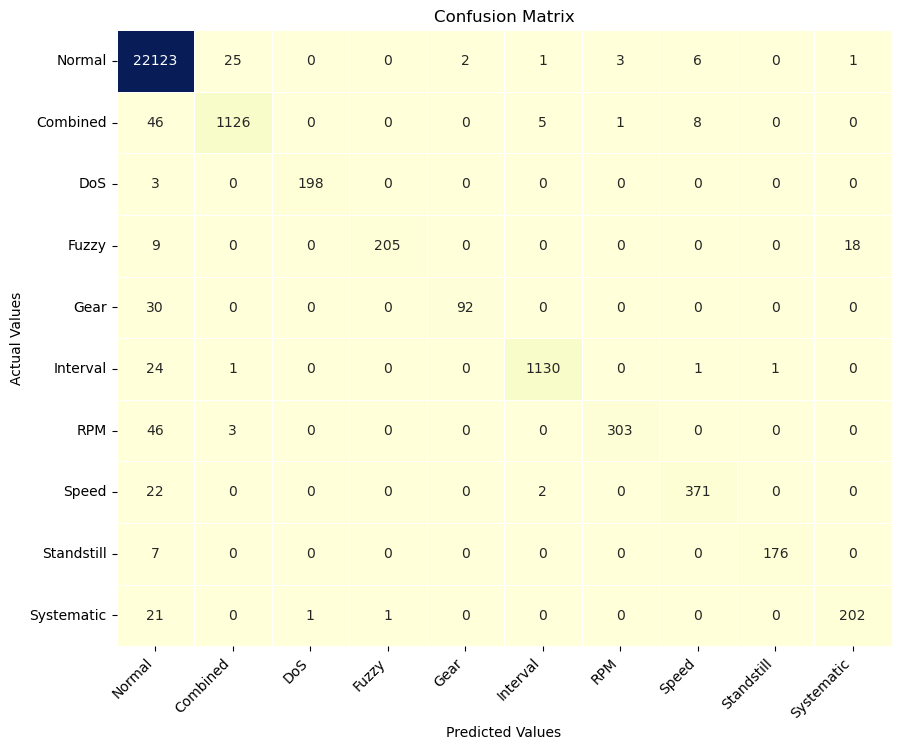

In [93]:
draw_confusion_matrix(cm, classes, save_dir='../pic/conf_matrix/confusion_matrix_unicon_can_ml_{}.png')

In [94]:
np.random.seed(100)
indices = np.empty(shape=(0), dtype=int)
num_samples = 1000
for c in range(n_classes):
    idx_c = np.where(total_label==c)[0]
    idx_c = np.random.choice(idx_c, num_samples, replace=True)
    indices = np.concatenate((indices, idx_c), axis=0)

In [95]:
total_embs[indices] /= 10**2
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu trước khi đưa vào t-SNE
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(total_embs[indices])

In [96]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1, perplexity=50)
new_embs = tsne.fit_transform(total_embs[indices])

In [97]:
def plot_embeddings(embeddings, targets, xlim=None, ylim=None, save_dir=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)
    plt.savefig(save_dir.format(ckpt_epoch), dpi=300)

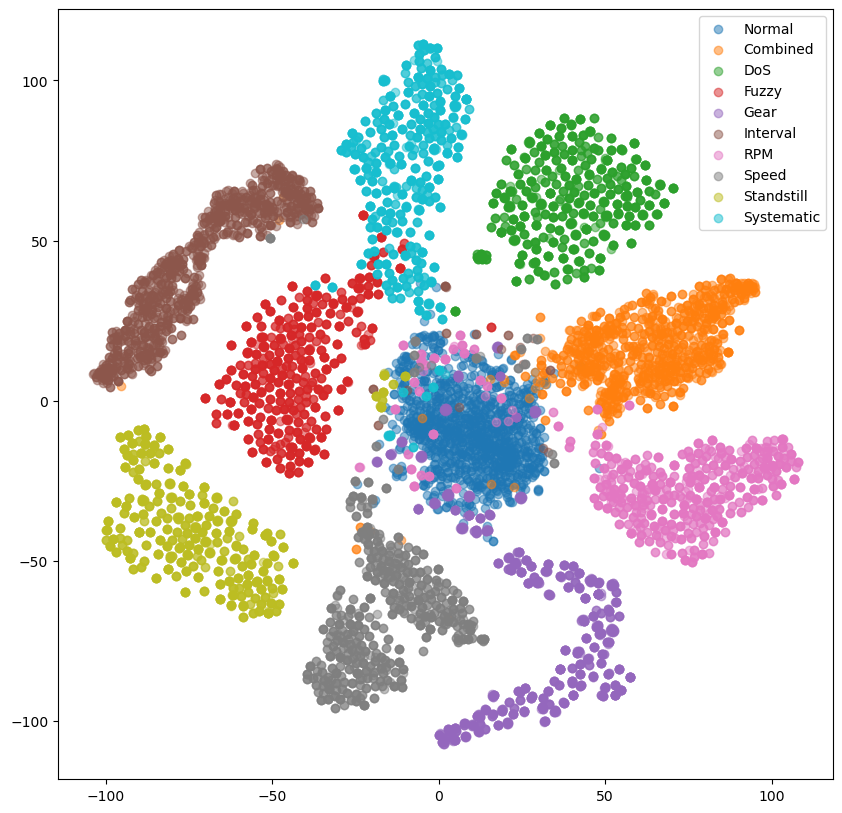

In [98]:
plot_embeddings(new_embs, total_label[indices], save_dir='../pic/tsne/tsne_unicon_can_ml_{}.png')